In [1]:
DATA_DIR = "benchmark-many-gpus"

In [2]:
%matplotlib inline

In [3]:
XFER_TYPE_MAPPING = {
        0: "Storage->GPU (GDS)",
        1: "Storage->CPU",
        2: "Storage->CPU->GPU",
        3: "Storage->CPU->GPU_ASYNC",
#         4: "Storage->PAGE_CACHE->CPU->GPU",
        5: "Storage->GPU_ASYNC",
#         6: "Storage->GPU_BATCH" # Experiments failed
    }

In [4]:
OPERATION_TYPE_MAPPING = {
        0: "read",
        1: "write",
        2: "randread",
        3: "randwrite"
    }

In [5]:
xfer_types_to_skip = set(range(7)).difference(XFER_TYPE_MAPPING)
print(xfer_types_to_skip)

{4, 6}


# Throughput and latency

In [6]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns

In [7]:
def parse_xfer_type(type_):
    return XFER_TYPE_MAPPING[int(type_)]

In [8]:
def parse_operation_type(type_):
    return OPERATION_TYPE_MAPPING[int(type_)]

In [9]:
params_path_pattern = r"benchmark-(\d+)-([^-]+)-\d+-([01])-" # "benchmark-$X-$RW-$W-${ENABLE_NVLINKS}-${SLURM_JOB_ID}"
results_pattern = r"Throughput: ([^\s]+) GiB/sec, Avg_Latency: ([^\s]+) usecs"

measurements = []


def read_from_path(suffix, num_gpus):
    data_dir = DATA_DIR + suffix
    pathlist = Path(data_dir).glob('slurm-benchmark-*.out')

    for path in pathlist:
        with open(path, "r") as f:
            content = f.read()
        slurm_job_id = re.search(r"slurm-benchmark-(\d+).out", str(path)).group(1)

        results_dir = next(Path(data_dir).glob(f"benchmark-*-{slurm_job_id}"))

        params_match = re.search(params_path_pattern, str(results_dir))
        results_match = re.search(results_pattern, content)
        if int(params_match.group(1)) in xfer_types_to_skip:
            continue
        measurements.append({
            "xfer_type": parse_xfer_type(params_match.group(1)),
            "op_type": params_match.group(2),
            "nvlink": params_match.group(3) == "1",
            "num_gpus": num_gpus,
            "throughput (GiB/sec)": float(results_match.group(1)),
            "latency (usecs)": float(results_match.group(2))
        })

read_from_path("", 8)
read_from_path("-one-gpu", 1)
measurements_df = pd.DataFrame(measurements)

In [10]:
measurements_df["xfer_type"] = measurements_df["xfer_type"].astype(
    CategoricalDtype(categories=XFER_TYPE_MAPPING.values(), ordered=True)
)
measurements_df["op_type"] = measurements_df["op_type"].astype(
    CategoricalDtype(categories=OPERATION_TYPE_MAPPING.values(), ordered=True)
)

In [11]:
measurements_df

,xfer_type,op_type,nvlink,num_gpus,throughput (GiB/sec),latency (usecs)
0,Storage->GPU (GDS),randwrite,False,8,5.520532,24171.008179
1,Storage->CPU,write,True,8,13.485091,9265.503368
2,Storage->GPU (GDS),randread,True,8,14.337443,8868.180565
3,Storage->GPU_ASYNC,randread,True,8,14.395637,8832.253261
4,Storage->GPU_ASYNC,randwrite,True,8,5.489221,23230.258427
...,...,...,...,...,...,...
75,Storage->CPU->GPU,randread,True,1,9.053208,1725.049831
76,Storage->CPU,read,True,1,21.748362,718.294686
77,Storage->GPU_ASYNC,randwrite,False,1,6.087944,2566.485533
78,Storage->GPU (GDS),read,False,1,18.534524,842.650806


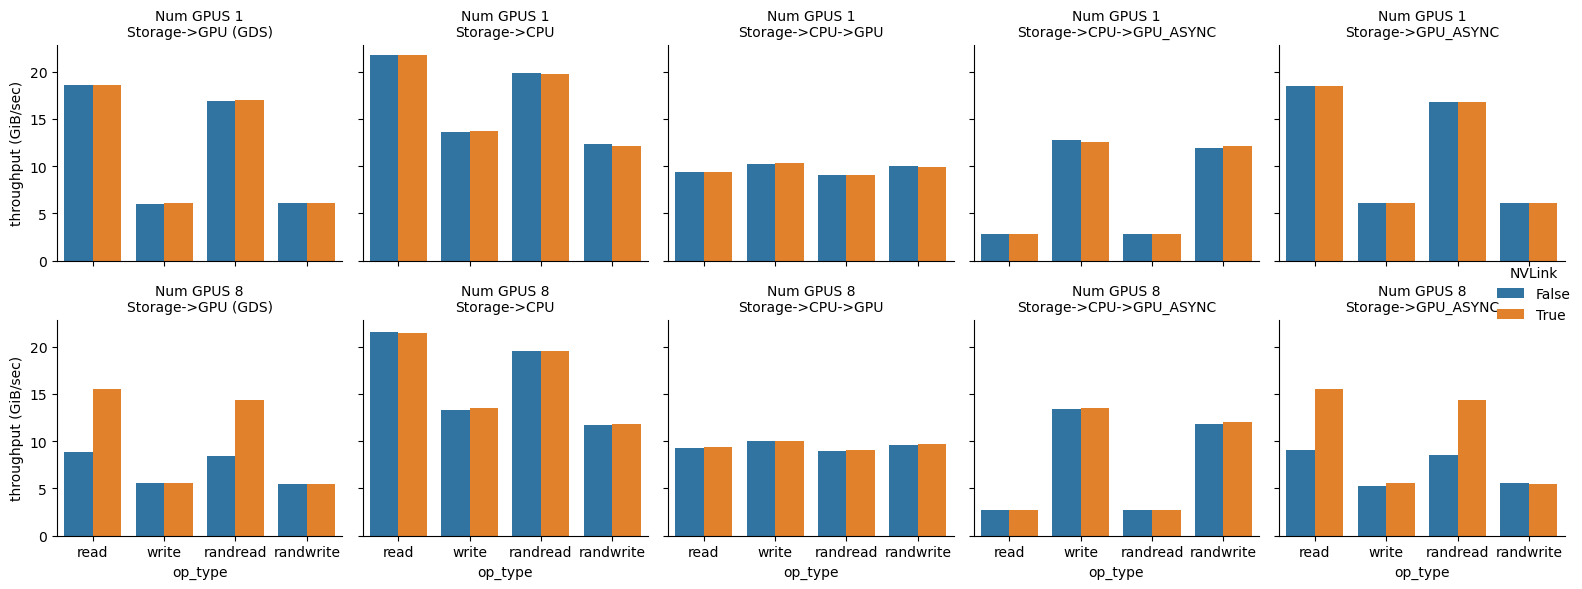

In [12]:
g = sns.FacetGrid(measurements_df, col="xfer_type", row="num_gpus")
g.set_titles("Num GPUS {row_name}\n{col_name}")
g.map_dataframe(
    sns.barplot, x="op_type", y="throughput (GiB/sec)", hue="nvlink",
    palette=sns.color_palette(n_colors=2)
)
g.add_legend(title="NVLink")
plt.tight_layout()
plt.savefig(f"{DATA_DIR}/throughput-dgx-4-raid.eps", format="eps")
plt.show()

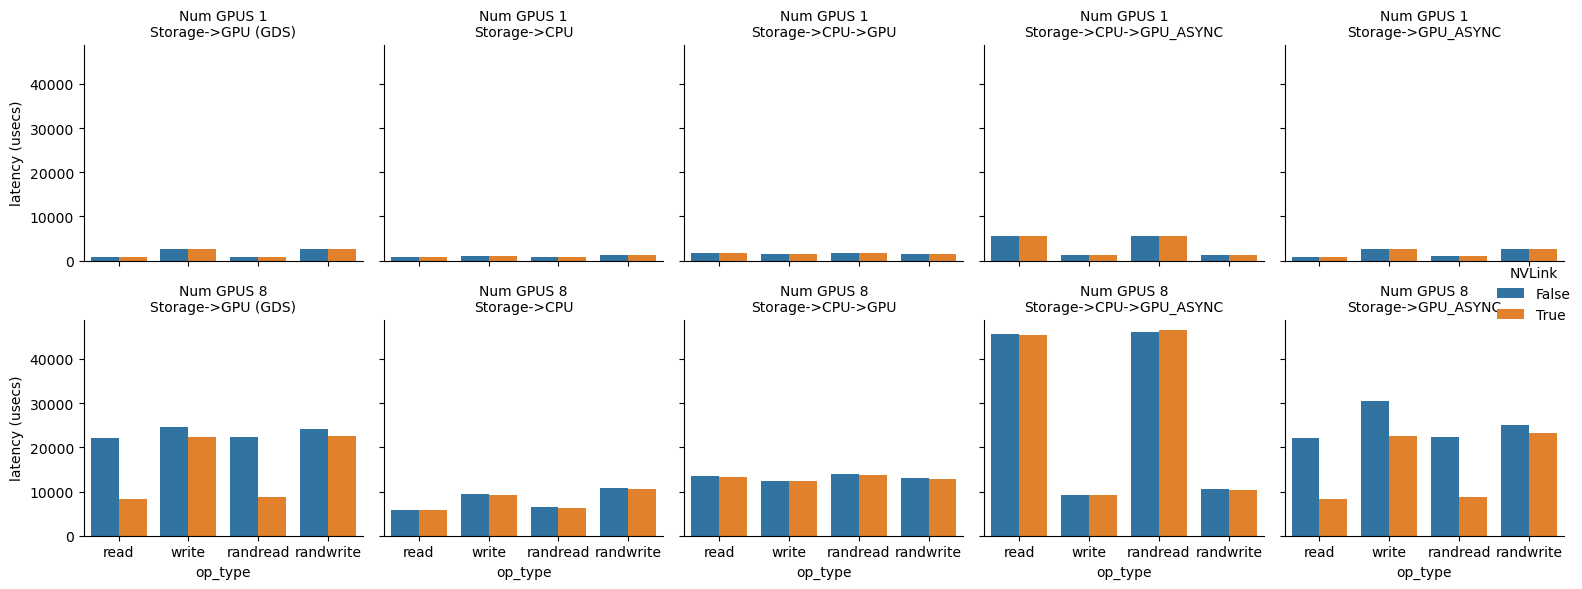

In [13]:
g = sns.FacetGrid(measurements_df, col="xfer_type", row="num_gpus")
g.set_titles("Num GPUS {row_name}\n{col_name}")
g.map_dataframe(
    sns.barplot, x="op_type", y="latency (usecs)", hue="nvlink",
    palette=sns.color_palette(n_colors=2)
)
g.add_legend(title="NVLink")
plt.tight_layout()
plt.savefig(f"{DATA_DIR}/latency-dgx-4-raid.eps", format="eps")
plt.show()

# Disk throughput

In [14]:
io_metrics_names = "r/s     rMB/s   rrqm/s  %rrqm r_await rareq-sz     w/s     wMB/s   wrqm/s  %wrqm w_await wareq-sz     d/s     dMB/s   drqm/s  %drqm d_await dareq-sz  aqu-sz  %util".split()
single_metrics_pattern = r"\s+([^\s]+)"
disk_usage_pattern = r"\n([^\s]+)" + "".join(single_metrics_pattern for _ in range(len(io_metrics_names)))

def try_parse_number(str_value):
    try:
        return int(str_value)
    except ValueError:
        pass
    try:
        return float(str_value)
    except ValueError:
        pass
    return str_value

iostat_measurements = []

def read_disk_from_path(suffix, num_gpus):
    data_dir = DATA_DIR + suffix
    pathlist = Path(data_dir).glob('benchmark-*')

    for path in pathlist:
        with open(path / "iostat.out", "r") as f:
            content = f.read()

        params_match = re.search(params_path_pattern, str(path))

        if int(params_match.group(1)) in xfer_types_to_skip:
            continue

        for i, chunk in enumerate(re.findall(
            r"Device            r/s     rMB/s   rrqm/s  %rrqm r_await rareq-sz     w/s     wMB/s   wrqm/s  %wrqm w_await wareq-sz     d/s     dMB/s   drqm/s  %drqm d_await dareq-sz  aqu-sz  %util(?:\r?\n(?!\r?\n).*)*",
            content
        )[2:-1], start=1):
            measurements = re.findall(disk_usage_pattern, chunk)
            for measurement in measurements:

                if measurement[0] in {"md1", "nvme0n1", "nvme3n1", "nvme4n1", "nvme5n1"}:

                    iostat_measurements.append({
                        "xfer_type": parse_xfer_type(params_match.group(1)),
                        "op_type": params_match.group(2),
                        "nvlink": params_match.group(3) == "1",
                        "observation_index": i,
                        "num_gpus": num_gpus,
                        **dict(zip(["disk_device"] + io_metrics_names, (try_parse_number(x) for x in measurement)))
                    })

read_disk_from_path("", 8)
read_disk_from_path("-one-gpu", 1)
iostat_measurements_df = pd.DataFrame(iostat_measurements)

In [15]:
iostat_measurements_df["xfer_type"] = iostat_measurements_df["xfer_type"].astype(
    CategoricalDtype(categories=XFER_TYPE_MAPPING.values(), ordered=True)
)
iostat_measurements_df["op_type"] = iostat_measurements_df["op_type"].astype(
    CategoricalDtype(categories=OPERATION_TYPE_MAPPING.values(), ordered=True)
)
iostat_measurements_df["disk_device"] = iostat_measurements_df["disk_device"].astype('category')

In [16]:
iostat_measurements_df

,xfer_type,op_type,nvlink,observation_index,num_gpus,disk_device,r/s,rMB/s,rrqm/s,%rrqm,...,w_await,wareq-sz,d/s,dMB/s,drqm/s,%drqm,d_await,dareq-sz,aqu-sz,%util
0,Storage->CPU->GPU,randread,True,1,8,md1,92373.8,10370.88,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
1,Storage->CPU->GPU,randread,True,1,8,nvme0n1,22987.6,2366.87,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,99.84
2,Storage->CPU->GPU,randread,True,1,8,nvme3n1,23072.4,2329.14,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,99.84
3,Storage->CPU->GPU,randread,True,1,8,nvme4n1,23370.6,2336.86,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,99.84
4,Storage->CPU->GPU,randread,True,1,8,nvme5n1,22943.2,2299.13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,99.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,Storage->CPU->GPU_ASYNC,randread,True,4,1,md1,28047.8,3159.71,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
1981,Storage->CPU->GPU_ASYNC,randread,True,4,1,nvme0n1,6754.0,699.88,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,99.92
1982,Storage->CPU->GPU_ASYNC,randread,True,4,1,nvme3n1,7007.6,708.92,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,99.92
1983,Storage->CPU->GPU_ASYNC,randread,True,4,1,nvme4n1,7110.2,711.98,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,99.92


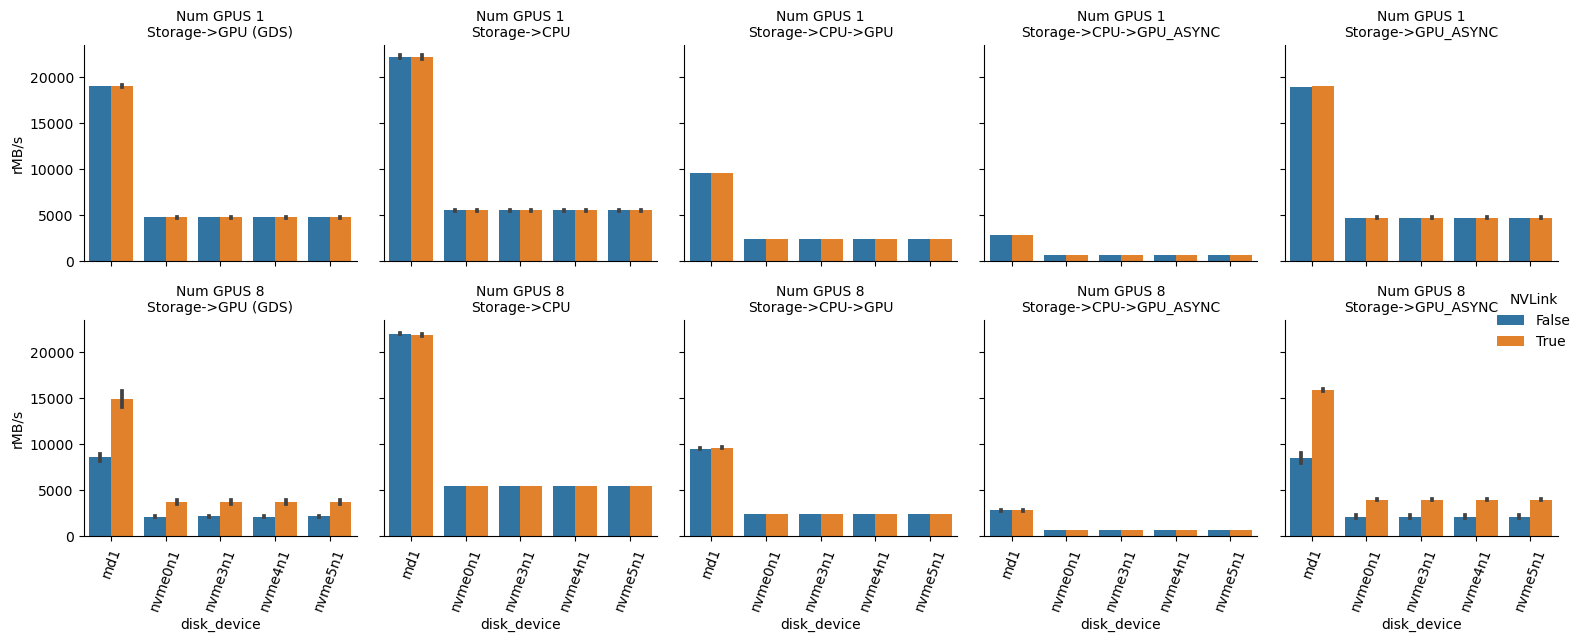

In [17]:
g = sns.FacetGrid(
    iostat_measurements_df[iostat_measurements_df.op_type == "read"], col="xfer_type", row="num_gpus")
g.set_titles("Num GPUS {row_name}\n{col_name}")
g.map_dataframe(
    sns.barplot, x="disk_device", y="rMB/s", hue="nvlink", errorbar="se",
    palette=sns.color_palette(n_colors=iostat_measurements_df.disk_device.nunique())
)
g.add_legend(title="NVLink")
plt.tight_layout()
[plt.setp(ax.get_xticklabels(), rotation=70) for ax in g.axes.flat]
plt.savefig(f"{DATA_DIR}/iostat-read-dgx-4-raid.eps", format="eps")
plt.show()

# CPU burden

In [18]:
single_metrics_pattern = r"\s*([^\s]+)"
cpu_usage_pattern = rf"avg-cpu:  %user   %nice %system %iowait  %steal   %idle\n{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}"

In [19]:
cpu_measurements = []

def read_cpu_from_path(suffix, num_gpus):
    data_dir = DATA_DIR + suffix
    pathlist = Path(data_dir).glob('benchmark-*')

    for path in pathlist:
        with open(path / "iostat.out", "r") as f:
            content = f.read()

        cpu_matches = re.findall(cpu_usage_pattern, content)
        params_match = re.search(params_path_pattern, str(path))

        if int(params_match.group(1)) in xfer_types_to_skip:
            continue

        for i, cpu_match in enumerate(cpu_matches[1:-1], start=1):
            cpu_measurements.append({
                "xfer_type": parse_xfer_type(params_match.group(1)),
                "op_type": params_match.group(2),
                "nvlink": params_match.group(3) == "1",
                "observation_index": i,
                "num_gpus": num_gpus,
                **dict(zip(["user_cpu", "nice_cpu", "system_cpu", "iowait_cpu", "steal_cpu", "idle_cpu"], cpu_match))
            })

read_cpu_from_path("", 8)
read_cpu_from_path("-one-gpu", 1)
cpu_measurements_df = pd.DataFrame(cpu_measurements)

In [20]:
cpu_measurements_df["xfer_type"] = cpu_measurements_df["xfer_type"].astype(
    CategoricalDtype(categories=XFER_TYPE_MAPPING.values(), ordered=True)
)
cpu_measurements_df["op_type"] = cpu_measurements_df["op_type"].astype(
    CategoricalDtype(categories=OPERATION_TYPE_MAPPING.values(), ordered=True)
)
for col in cpu_measurements_df.columns:
    if col.endswith("cpu"):
        cpu_measurements_df[col] = cpu_measurements_df[col].astype(float)

In [21]:
cpu_measurements_df

,xfer_type,op_type,nvlink,observation_index,num_gpus,user_cpu,nice_cpu,system_cpu,iowait_cpu,steal_cpu,idle_cpu
0,Storage->CPU->GPU,randread,True,1,8,0.23,0.0,0.70,0.0,0.0,99.08
1,Storage->CPU->GPU,randread,True,2,8,0.46,0.0,0.39,0.0,0.0,99.16
2,Storage->CPU->GPU,randread,True,3,8,0.43,0.0,0.36,0.0,0.0,99.20
3,Storage->CPU->GPU,randread,True,4,8,0.68,0.0,0.41,0.0,0.0,98.92
4,Storage->CPU->GPU,randread,True,5,8,0.43,0.0,0.41,0.0,0.0,99.16
...,...,...,...,...,...,...,...,...,...,...,...
472,Storage->CPU->GPU_ASYNC,randread,True,1,1,0.12,0.0,0.78,0.0,0.0,99.10
473,Storage->CPU->GPU_ASYNC,randread,True,2,1,0.16,0.0,0.68,0.0,0.0,99.16
474,Storage->CPU->GPU_ASYNC,randread,True,3,1,0.12,0.0,0.70,0.0,0.0,99.18
475,Storage->CPU->GPU_ASYNC,randread,True,4,1,0.20,0.0,0.76,0.0,0.0,99.04


In [22]:
cpu_measurements_df.groupby(["xfer_type", "op_type", "nvlink", "num_gpus"]).count().min()

observation_index    4
user_cpu             4
nice_cpu             4
system_cpu           4
iowait_cpu           4
steal_cpu            4
idle_cpu             4
dtype: int64

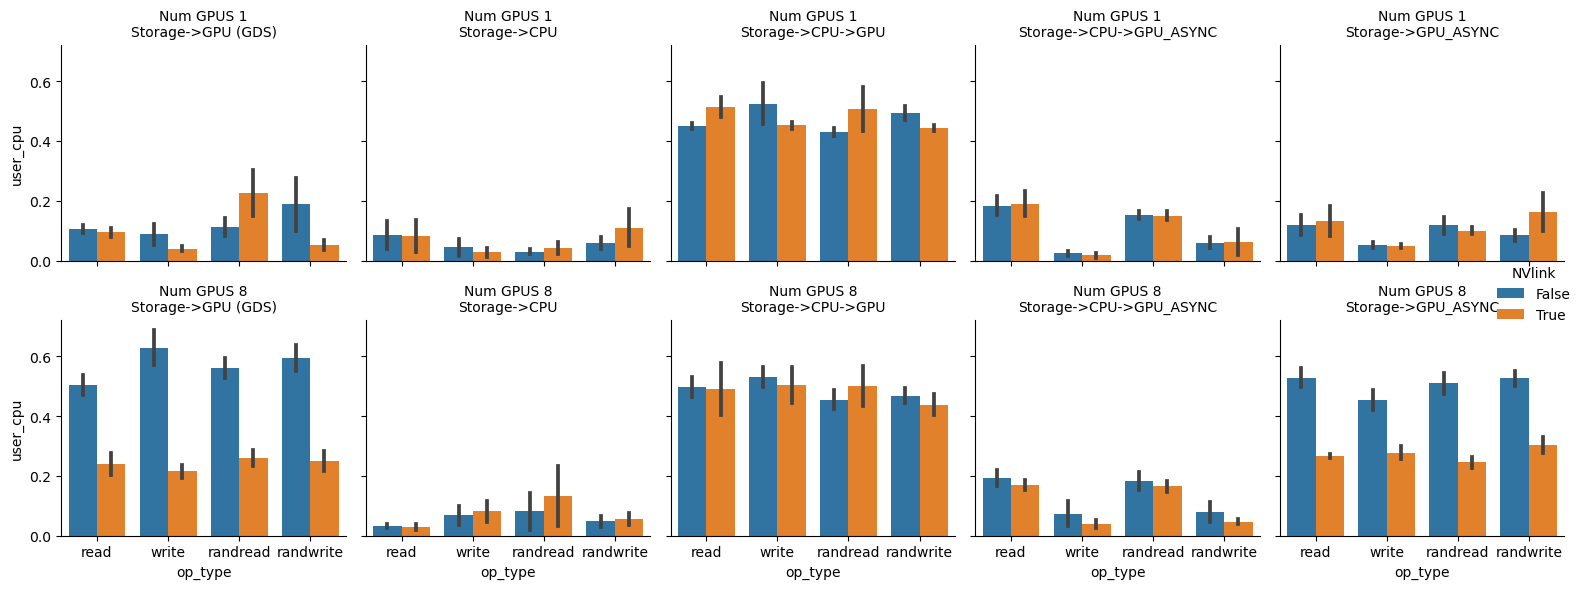

In [23]:
g = sns.FacetGrid(cpu_measurements_df, col="xfer_type", row="num_gpus")
g.set_titles("Num GPUS {row_name}\n{col_name}")
g.map_dataframe(
    sns.barplot, x="op_type", y="user_cpu", hue="nvlink", errorbar="se",
    palette=sns.color_palette(n_colors=2)
)
g.add_legend(title="NVlink")
plt.tight_layout()
plt.savefig(f"{DATA_DIR}/cpu-user-dgx-4-raid.eps", format="eps")
plt.show()

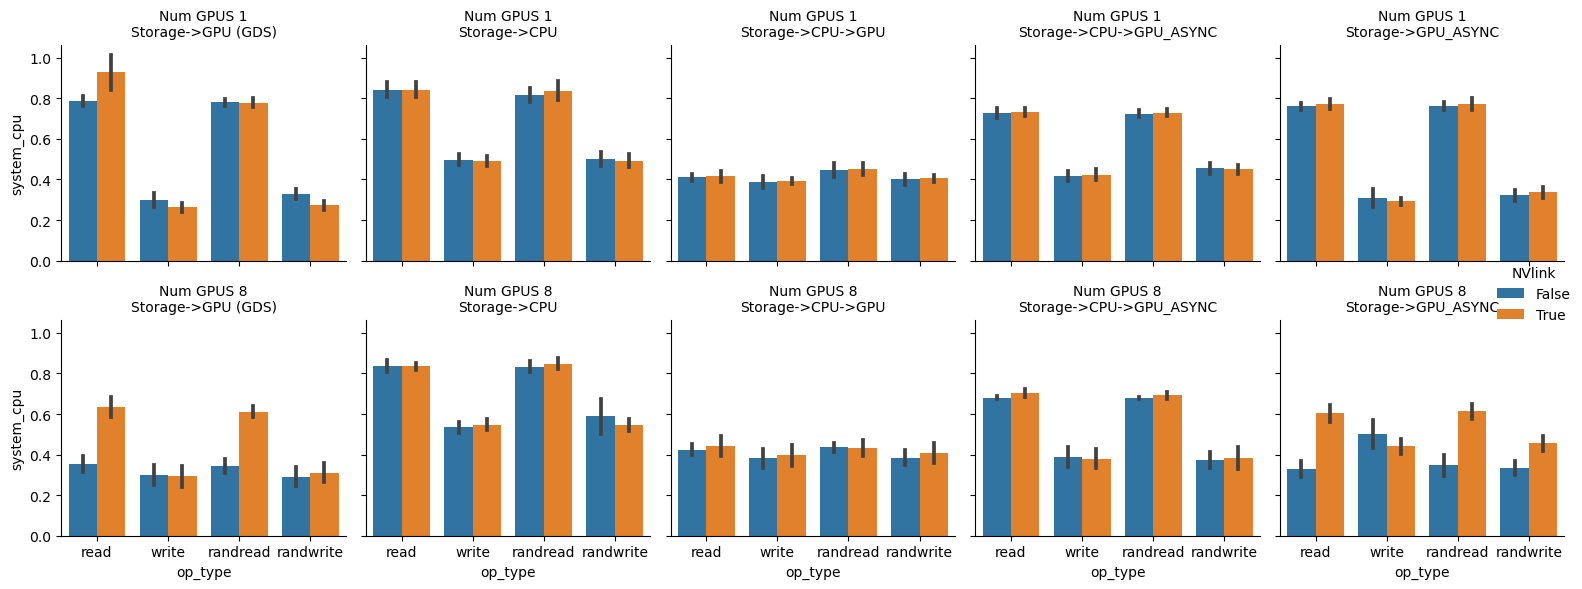

In [24]:
g = sns.FacetGrid(cpu_measurements_df, col="xfer_type", row="num_gpus")
g.set_titles("Num GPUS {row_name}\n{col_name}")
g.map_dataframe(
    sns.barplot, x="op_type", y="system_cpu", hue="nvlink", errorbar="se",
    palette=sns.color_palette(n_colors=2)
)
g.add_legend(title="NVlink")
plt.tight_layout()
plt.savefig(f"{DATA_DIR}/cpu-system-dgx-4-raid.eps", format="eps")
plt.show()